# Dependencies

In [2]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
from cyipopt import minimize_ipopt
import warnings
import matplotlib.pyplot as plt
from jax.config import config
# Enable 64 bit floating point precision
config.update("jax_enable_x64", True)

# We use the CPU instead of GPU und mute all warnings if no GPU/TPU is found.
config.update('jax_platform_name', 'cpu')

# import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev
from tqdm.contrib.telegram import tqdm, trange
from dotenv import load_dotenv
import os

from bob_telegram_tools.bot import TelegramBot
load_dotenv()
import pyreadr
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm
ranepa_colors = [(146/250,26/250,29/250)
,(230/250 , 43/250, 37/250)
,(231/250, 142/250, 36/250)
,(249/250, 155/250, 28/250)
, (242/250, 103/250, 36/250)]

# OLG model

In [3]:
%load_ext autoreload
%autoreload 2
from olg import *

- Exogenous labor

Params: $\phi$

$$labor[t] = \phi_s$$

- Endogenous labor

Params:  $\iota$, $\upsilon$

$$ labor[t] = \left[\frac{LaborIncome[t]} {consumption[t] * \iota * (1+\tau_{VA}[t])*price[t]}\right]^{1/\upsilon}$$

In [4]:
with open('result/baseline_mid_demo_mid_oil_exo.file', 'rb') as f:
    olg_exogenous_labor = pickle.load(f)

 $$u(c_{s,g,t}, l_{s,g, t})=
     \log c_{s,g,t} -  \frac{\iota}{1+\upsilon} {l_{s,g,t}}^{1+\upsilon}, $$

$$ \iota  = \frac{LaborIncome[t]} {consumption[t]  * labor^\upsilon * (1+\tau_{VA}[t])*price[t]}$$

In [5]:
endogenous_iota = np.array([np.nanmean(labor_income_vector(olg_exogenous_labor, s, default.G_MODEL-1, 0, default.G_MODEL)/\
    (olg_exogenous_labor.c[s,default.G_MODEL-1, :default.G_MODEL]*\
     olg_exogenous_labor.l[s,default.G_MODEL-1, :default.G_MODEL]**(olg_exogenous_labor.upsilon) *\
     (1+olg_exogenous_labor.tau_VA[:default.G_MODEL])*olg_exogenous_labor.price[:default.G_MODEL])) for s in range(2)])
print(endogenous_iota)

[0.9551527  0.23271612]


/tmp/ipykernel_77207/421840932.py:1: RuntimeWarning: invalid value encountered in divide
  endogenous_iota = np.array([np.nanmean(labor_income_vector(olg_exogenous_labor, s, default.G_MODEL-1, 0, default.G_MODEL)/\


In [7]:
olg_endogenous_labor = OLG_model(
                   upsilon = 5.,
                    eta = 0.1, T=300
                 , iota = endogenous_iota
                 , utility = "hybrid")

In [14]:
for i in range(10):
    olg_endogenous_labor.update_steady_state()

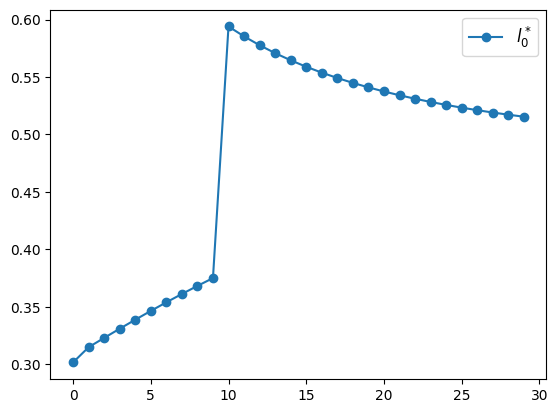

In [15]:
plt.plot([i[0]['info']['x'][6] for i in olg_endogenous_labor.steady_state_path], label = '$l_0^*$',marker='o')
plt.legend()
plt.show()

In [20]:
olg_endogenous_labor.update_a_initial()
olg_endogenous_labor.create_guess(t_0=1,steady_start = 200)

/home/mkhlgrv/science/olg/olg.py:505: RuntimeWarning: invalid value encountered in power
  ) * x**(-1/self.upsilon)


KeyboardInterrupt: 

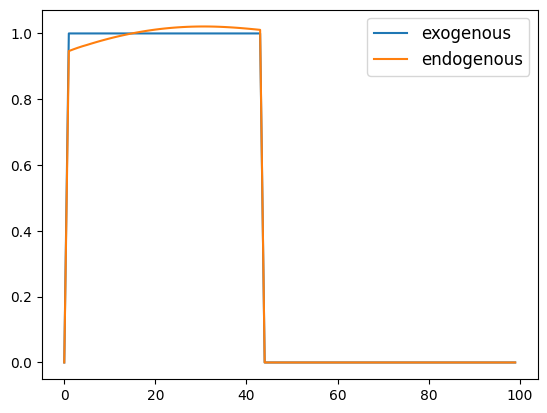

In [21]:
t = 100
plt.plot(range(t), olg_exogenous_labor.l[0,80,:t], label = "exogenous")
plt.plot(range(t), olg_endogenous_labor.l[0,80,:t], label = "endogenous")
plt.legend()
plt.show()

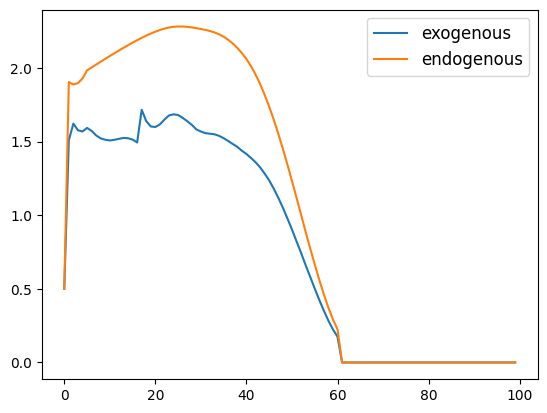

In [22]:
t = 100
plt.plot(range(t), olg_exogenous_labor.c[0,60,:t], label = "exogenous")
plt.plot(range(t), olg_endogenous_labor.c[0,60,:t], label = "endogenous")
plt.legend()
plt.show()

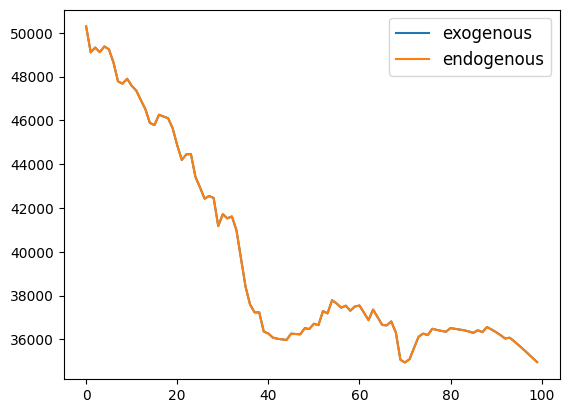

In [23]:
t = 100
plt.plot(range(t), olg_exogenous_labor.Labor[:t], label = "exogenous")
plt.plot(range(t), olg_endogenous_labor.Labor[:t], label = "endogenous")
plt.legend()
plt.show()